In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import seaborn as sns
import folium
import statsmodels.api as sm

sns.set(style='darkgrid')
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
orange = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)

In [4]:
cd ..

/home/tom/Documents/dsi/capstones/RestaurantInspections


In [5]:
from src.helper_funcs import *

In [2]:
# Set up dataframes
trim = setup_df('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [3]:
trim_inc = get_income_df(trim)

In [4]:
recent = trim_inc.groupby('CAMIS')['INSPECTION DATE'].max().reset_index()
recent.rename({'INSPECTION DATE': 'most_recent'}, inplace=True, axis=1)
recent.set_index('CAMIS', inplace=True)
trim_inc_recent = trim_inc.join(recent, on='CAMIS', how='left')
unique_df = trim_inc_recent[trim_inc_recent['INSPECTION DATE'] == trim_inc_recent.most_recent]
unique_df = unique_df.drop_duplicates(subset='CAMIS').reset_index().drop('index',axis=1)

### Making a new dataframe, unique restaurants grouped by Zip Code with corresponding numerical figures for scores, grades, income, num restaurants

In [5]:
zipcode_data = get_zipcode_groups(unique_df)

In [6]:
zipcode_data

,ZIPCODE,mean_score,median_score,A,B,C,total_graded,percentage_A
0,10000,11.500000,11.5,2,0,0,2,100.000000
1,10001,11.137045,10.0,395,21,6,422,93.601896
2,10002,12.520697,11.0,346,26,2,374,92.513369
3,10003,11.552066,11.0,487,47,5,539,90.352505
4,10004,10.128788,10.0,115,3,2,120,95.833333
...,...,...,...,...,...,...,...,...
218,11691,11.625000,10.5,36,2,0,38,94.736842
219,11692,8.181818,9.0,11,0,0,11,100.000000
220,11693,10.060606,10.0,31,2,0,33,93.939394
221,11694,10.405405,11.0,34,0,0,34,100.000000


In [7]:
zipcode_data.total_graded.sum()

21282

In [8]:
zipcode_data['Median_Income'] = 0
search = SearchEngine()
for idx, row in zipcode_data.iterrows():
    income = search.by_zipcode(int(row['ZIPCODE'])).median_household_income
    zipcode_data.loc[idx, 'Median_Income'] = income

In [9]:
zipcode_clean = zipcode_data.copy()
zipcode_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZIPCODE        223 non-null    object 
 1   mean_score     223 non-null    float64
 2   median_score   223 non-null    float64
 3   A              223 non-null    int64  
 4   B              223 non-null    int64  
 5   C              223 non-null    int64  
 6   total_graded   223 non-null    int64  
 7   percentage_A   221 non-null    float64
 8   Median_Income  180 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 15.8+ KB


### __Plot zipcode's Percentage of A-graded Restaurants and the zipcode's Median Income. Create a linear model based on these two variables.__
First we need to clean the data. Let's drop nulls, outliers, and zipcodes where the number of graded restaurants was <24


In [10]:
zipcode_clean.dropna(inplace=True)

In [11]:
zipcode_clean.describe()

,mean_score,median_score,A,B,C,total_graded,percentage_A,Median_Income
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,11.268963,10.511111,107.527778,6.238889,1.527778,115.294444,93.076704,63578.522222
std,1.275749,0.855406,100.542630,6.547944,1.712362,107.248247,5.540650,31360.507034
min,7.500000,7.500000,1.000000,0.000000,0.000000,2.000000,50.000000,20232.000000
25%,10.566288,10.000000,38.750000,2.000000,0.000000,42.000000,91.081703,42845.500000
50%,11.261282,10.500000,75.000000,5.000000,1.000000,84.000000,93.939394,57499.500000
75%,11.786551,11.000000,137.500000,9.000000,2.000000,146.750000,96.010554,78297.250000
max,17.062500,13.000000,538.000000,47.000000,8.000000,564.000000,100.000000,230952.000000


In [12]:
index_list = zipcode_clean.sort_values(by='total_graded', ascending=True).head(24).index.tolist()

In [13]:
zipcode_clean.drop(index=index_list,axis=0,inplace=True)

In [14]:
zipcode_clean.sort_values(by='Median_Income')

,ZIPCODE,mean_score,median_score,A,B,C,total_graded,percentage_A,Median_Income
96,10454,13.605263,11.0,53,9,3,65,81.538462,20232.0
102,10460,9.703125,9.0,54,2,0,56,96.428571,22307.0
97,10455,12.389474,10.0,74,9,1,84,88.095238,22609.0
98,10456,11.253333,10.0,60,5,1,66,90.909091,23452.0
101,10459,11.942029,11.0,55,1,1,57,96.491228,24461.0
...,...,...,...,...,...,...,...,...,...
6,10006,10.116279,10.0,39,1,2,42,92.857143,119274.0
5,10005,10.187500,9.5,59,1,2,62,95.161290,124670.0
4,10004,10.128788,10.0,115,3,2,120,95.833333,129313.0
77,10280,8.068966,9.0,27,0,0,27,100.000000,129574.0


In [15]:
zipcode_clean1 = zipcode_clean.drop(zipcode_clean[zipcode_clean.ZIPCODE == '10007'].index.tolist(), axis=0)

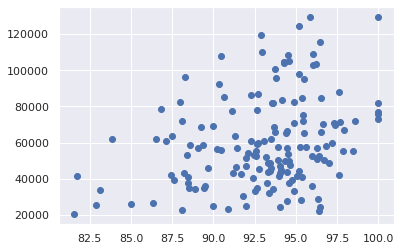

In [16]:
plt.scatter(zipcode_clean1.percentage_A, zipcode_clean1.Median_Income)

In [17]:
X = sm.add_constant(zipcode_clean1.percentage_A)
y = zipcode_clean1.Median_Income
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Median_Income   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     15.84
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           0.000106
Time:                        16:25:24   Log-Likelihood:                -1781.1
No. Observations:                 155   AIC:                             3566.
Df Residuals:                     153   BIC:                             3572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.333e+05   4.87e+04     -2.736      0.007    -2.3e+05    -3.7e+04
percentage_A  2082.1011    523.138      3.980      0.000    1048.595    3115.608
==============================================================================
Omnibus:                       10.776   Durbin-Watson:                   0.924
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.775
Skew:                           0.671   Prob(JB):                      0.00277
Kurtosis:                       2.842   Cond. No.                     2.37e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

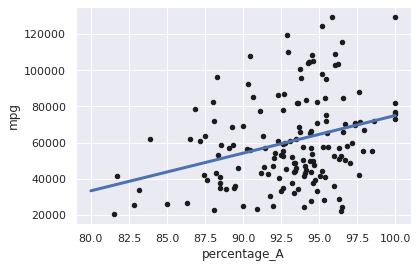

In [18]:
xx = np.linspace(80, 100)
best_line = results.params['const'] + results.params['percentage_A']*xx
plt.scatter(X['percentage_A'],y, color='k', s=20)
plt.xlabel('percentage_A')
plt.ylabel('mpg')
plt.plot(xx, best_line, color='b', lw=3);

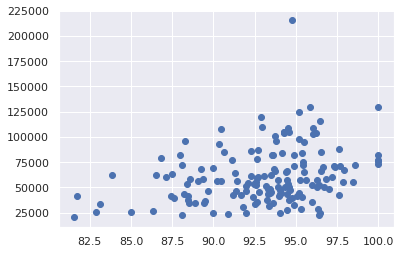

In [19]:
plt.scatter(zipcode_clean.percentage_A, zipcode_clean.Median_Income)


In [20]:
import statsmodels.api as sm


In [21]:
X = sm.add_constant(zipcode_clean.percentage_A)
y = zipcode_clean.Median_Income
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Median_Income   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     14.22
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           0.000232
Time:                        16:25:25   Log-Likelihood:                -1810.3
No. Observations:                 156   AIC:                             3625.
Df Residuals:                     154   BIC:                             3631.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.441e+05   5.46e+04     -2.641      0.009   -2.52e+05   -3.63e+04
percentage_A  2208.6102    585.774      3.770      0.000    1051.421    3365.799
==============================================================================
Omnibus:                       65.408   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.414
Skew:                           1.556   Prob(JB):                     9.37e-56
Kurtosis:                       8.413   Cond. No.                     2.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

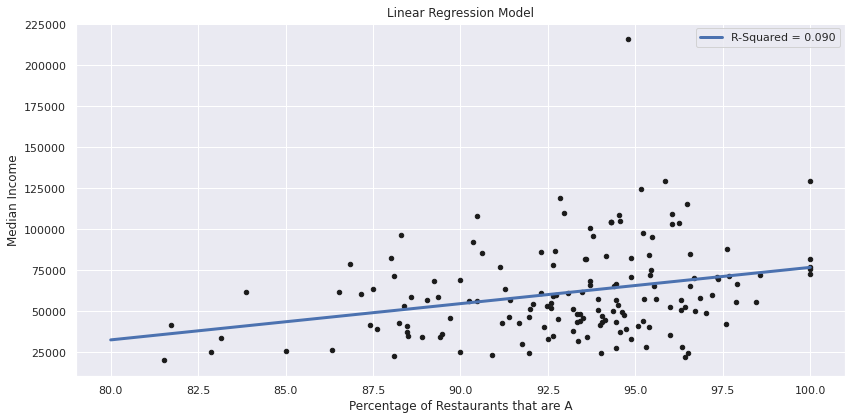

In [22]:
fig, ax = plt.subplots(figsize = (12,6))

xx = np.linspace(80, 100)
best_line = results.params['const'] + results.params['percentage_A']*xx
plt.scatter(X['percentage_A'],y, color='k', s=20)
plt.xlabel('Percentage of Restaurants that are A')
plt.ylabel('Median Income')
plt.plot(xx, best_line, color='b', lw=3, label = 'R-Squared = 0.090')
ax.legend()
plt.title('Linear Regression Model')


plt.tight_layout()
# plt.savefig('img/regression.png')
plt.show()

### __Choropleth maps for percentage A's and Incomes__

#### For these maps we are using the dataset with the 210k median income removed. Otherwise this datapoint causes the entire color scale to be skewed.

In [23]:
ny_geo = 'nyc_zip_code_tabulation_areas_polygons.geojson'

In [24]:
zipcode_clean1

,ZIPCODE,mean_score,median_score,A,B,C,total_graded,percentage_A,Median_Income
1,10001,11.137045,10.0,395,21,6,422,93.601896,81671.0
2,10002,12.520697,11.0,346,26,2,374,92.513369,33218.0
3,10003,11.552066,11.0,487,47,5,539,90.352505,92540.0
4,10004,10.128788,10.0,115,3,2,120,95.833333,129313.0
5,10005,10.187500,9.5,59,1,2,62,95.161290,124670.0
...,...,...,...,...,...,...,...,...,...
214,11434,12.364865,10.5,63,3,2,68,92.647059,59229.0
215,11435,11.600000,11.0,86,7,0,93,92.473118,53041.0
218,11691,11.625000,10.5,36,2,0,38,94.736842,39409.0
220,11693,10.060606,10.0,31,2,0,33,93.939394,50570.0


In [29]:
sns.__version__

'0.10.1'

In [25]:
percentage_map = choropleth_plot(ny_geo, zipcode_clean1, ['ZIPCODE', 'percentage_A'])

/home/tom/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [26]:
percentage_map

In [27]:
income_map = choropleth_plot_income(ny_geo, zipcode_clean1, ['ZIPCODE', 'Median_Income'])

In [28]:
income_map